In [191]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive')
# !pip install pennylane

import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1695677800.0482063
Mon Sep 25 21:36:40 2023


In [192]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

Setting of the main hyper-parameters of the model
=================================================

::: {.note}
::: {.title}
Note
:::

To reproduce the results of Ref. \[1\], `num_epochs` should be set to
`30` which may take a long time. We suggest to first try with
`num_epochs=1` and, if everything runs smoothly, increase it to a larger
value.
:::


In [193]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 5              # Number of training epochs
q_depth = 10                # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

We initialize a PennyLane device with a `default.qubit` backend.


In [194]:
dev = qml.device("default.qubit", wires=n_qubits)

We configure PyTorch to use CUDA only if available. Otherwise the CPU is
used.


In [195]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset loading
===============

::: {.note}
::: {.title}
Note
:::

The dataset containing images of *ants* and *bees* can be downloaded
[here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and
should be extracted in the subfolder `../_data/hymenoptera_data`.
:::

This is a very small dataset (roughly 250 images), too small for
training from scratch a classical or quantum model, however it is enough
when using *transfer learning* approach.

The PyTorch packages `torchvision` and `torch.utils.data` are used for
loading the dataset and performing standard preliminary image
operations: resize, center, crop, normalize, *etc.*


In [196]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/drive/MyDrive/Colab Notebooks/data/44 Class 4478 Brain Tumor Images Split 0.627 Shuffle Rename"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let us show a batch of the test data, just to have an idea of the
classification problem.


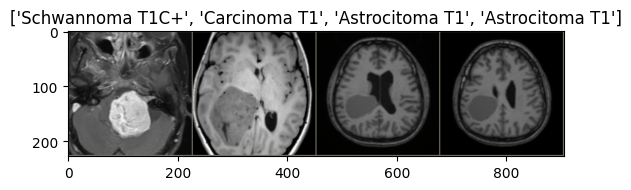

In [197]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

Variational quantum circuit
===========================

We first define some quantum layers that will compose the quantum
circuit.


In [198]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


Now we define the quantum circuit through the PennyLane
[qnode]{.title-ref} decorator .

The structure is that of a typical variational quantum circuit:

-   **Embedding layer:** All qubits are first initialized in a balanced
    superposition of *up* and *down* states, then they are rotated
    according to the input parameters (local embedding).
-   **Variational layers:** A sequence of trainable rotation layers and
    constant entangling layers is applied.
-   **Measurement layer:** For each qubit, the local expectation value
    of the $Z$ operator is measured. This produces a classical output
    vector, suitable for additional post-processing.


In [199]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

Dressed quantum circuit
=======================

We can now define a custom `torch.nn.Module` representing a *dressed*
quantum circuit.

This is a concatenation of:

-   A classical pre-processing layer (`nn.Linear`).
-   A classical activation function (`torch.tanh`).
-   A constant `np.pi/2.0` scaling.
-   The previously defined quantum circuit (`quantum_net`).
-   A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters
(features) and the output is a batch of vectors with two real outputs
(associated with the two classes of images: *ants* and *bees*).


In [200]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(2048, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 44)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)


Hybrid classical-quantum model
==============================

We are finally ready to build our full hybrid classical-quantum network.
We follow the *transfer learning* approach:

1.  First load the classical pre-trained network *ResNet18* from the
    `torchvision.models` zoo.
2.  Freeze all the weights since they should not be trained.
3.  Replace the last fully connected layer with our trainable dressed
    quantum circuit (`DressedQuantumNet`).

::: {.note}
::: {.title}
Note
:::

The *ResNet18* model is automatically downloaded by PyTorch and it may
take several minutes (only the first time).
:::


In [201]:
model_hybrid = torchvision.models.resnet50(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

Training and results
====================

Before training the network we need to specify the *loss* function.

We use, as usual in classification problem, the *cross-entropy* which is
directly available within `torch.nn`.


In [202]:
criterion = nn.CrossEntropyLoss()

We also initialize the *Adam optimizer* which is called at each training
step in order to update the weights of the model.


In [203]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of
`gamma_lr_scheduler` every 10 epochs.


In [204]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

What follows is a training function that will be called later. This
function should return a trained model that can be used to make
predictions (classifications).


In [205]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

We are ready to perform the actual training process.


In [206]:
from IPython.display import display, Javascript

# Run this cell to keep Colab awake
display(Javascript('''
  function keep_colab_awake(){
    console.log("Colab is being kept awake.");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
    document.querySelector("body > colab-sandbox-output > div > div.output.container.output-wrapper > div.output > pre").innerText;
    setTimeout(keep_colab_awake, 61000);
  }
  keep_colab_awake();
'''))

<IPython.core.display.Javascript object>

In [207]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/5 Loss: 3.6743 Acc: 0.0670        
Phase: validation   Epoch: 1/5 Loss: 3.5572 Acc: 0.0706        
Phase: train Epoch: 2/5 Loss: 3.5138 Acc: 0.0759        
Phase: validation   Epoch: 2/5 Loss: 3.4421 Acc: 0.0826        
Phase: train Epoch: 3/5 Loss: 3.4301 Acc: 0.0905        
Phase: validation   Epoch: 3/5 Loss: 3.3493 Acc: 0.1382        
Phase: train Epoch: 4/5 Loss: 3.3623 Acc: 0.1268        
Phase: validation   Epoch: 4/5 Loss: 3.2907 Acc: 0.1406        
Phase: train Epoch: 5/5 Loss: 3.3194 Acc: 0.1279        
Phase: validation   Epoch: 5/5 Loss: 3.2490 Acc: 0.1400        
Training completed in 29m 48s
Best test loss: 3.2490 | Best test accuracy: 0.1406


Visualizing the model predictions
=================================


We first define a visualization function for a batch of test data.


In [208]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with
the corresponding predictions.


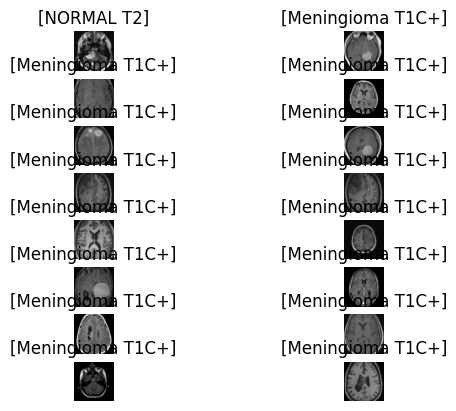

In [209]:
visualize_model(model_hybrid, num_images=16)
plt.show()

In [210]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1695679590.570495
Mon Sep 25 22:06:30 2023


In [211]:
# from google.colab import runtime
# runtime.unassign()

References
==========

\[1\] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and
Nathan Killoran. *Transfer learning in hybrid classical-quantum neural
networks*. arXiv:1912.08278 (2019).

\[2\] Rajat Raina, Alexis Battle, Honglak Lee, Benjamin Packer, and
Andrew Y Ng. *Self-taught learning: transfer learning from unlabeled
data*. Proceedings of the 24th International Conference on Machine
Learning\*, 759--766 (2007).

\[3\] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. *Deep
residual learning for image recognition*. Proceedings of the IEEE
Conference on Computer Vision and Pattern Recognition, 770-778 (2016).

\[4\] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin,
Carsten Blank, Keri McKiernan, and Nathan Killoran. *PennyLane:
Automatic differentiation of hybrid quantum-classical computations*.
arXiv:1811.04968 (2018).

About the author
================
